In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bs


In [2]:
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
np.random.seed = 100

In [3]:
plt.rcParams.update({'font.size': 14})

**Notebook Contents**

> 1. Loading and formatting data
> 2. Feature selection - by hand and with lasso regularization
> 3. Comparing lasso and ElasticNet results
> 4. Final model validation and results


## 1. Loading and formatting data

In [4]:
philly_cars = pd.read_csv('philly_dec2021.csv')
nyc_cars = pd.read_csv('nyc_dec2021.csv')


In [5]:
cars = nyc_cars

In [6]:
# philly_cars['city'] = 0
# nyc_cars['city'] = 1
# cars = nyc_cars.append(philly_cars)

In [7]:
cars['options'] = cars['options'].fillna('')

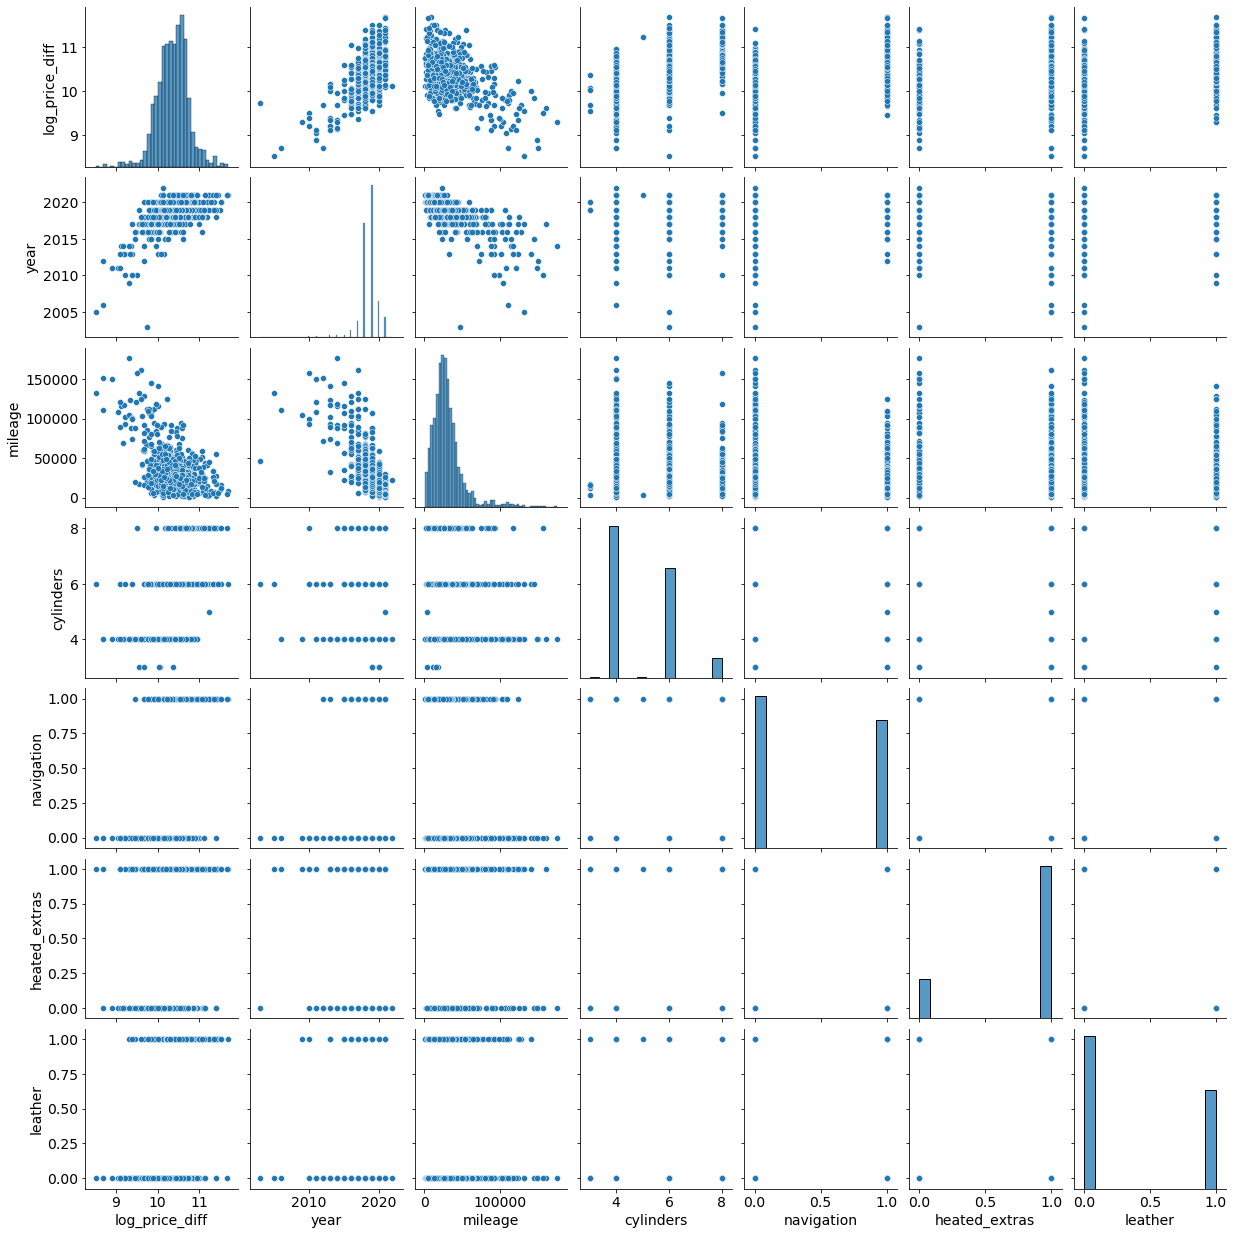

In [8]:
sns.pairplot(cars[['log_price_diff', 'year', 'mileage', 'cylinders', 'navigation', 'heated_extras', 
                    'leather']])

## 2. Feature selection and Lasso regularization

In [9]:
def standardize(X_train, X_test):
    std = StandardScaler()
    std.fit(X_train)

    X_train = std.transform(X_train)
    X_test = std.transform(X_test)

    return(X_train, X_test)

In [10]:
def optimize_ElasticNet(X_train, y_train, X_val, y_val):
    alphavec = 10**np.linspace(-5,2,200)

    en_model = ElasticNetCV(alphas = alphavec, l1_ratio=np.linspace(0.01,0.99,20), cv=5, fit_intercept=True)
    en_model.fit(X_train, y_train)
    
    print("alpha: " + str(en_model.alpha_))
    print("l1_ratio: " + str(en_model.l1_ratio_))
    print("R^2: " + str(en_model.score(X_val, y_val)))
    return en_model

In [11]:
def feature_coefs(X, model):
    coefs= pd.DataFrame(zip(X.columns, model.coef_)).set_index(0)

    coefs['abs_val'] = coefs[1].apply(np.abs)
    sorted_coefs = coefs[coefs['abs_val']>0].sort_values(by='abs_val', ascending=False)
    sorted_coefs = sorted_coefs.rename(columns = {1: 'coef'})
    sorted_coefs['price_ratio'] = sorted_coefs['coef'].apply(np.exp)
    
    return sorted_coefs
    

In [12]:
def check_assumptions(y, pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 2)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

In [13]:
def lasso_pipeline(X_train, y_train, X_val, y_val):
    
    def optimize_lasso(X_train, y_train):
        alphavec = 10**np.linspace(-4,2,200)

        lasso_model = LassoCV(alphas = alphavec, cv=5, fit_intercept=True)
        lasso_model.fit(X_train, y_train)

        print("alpha: " + str(lasso_model.alpha_))
        print("R^2: " + str(lasso_model.score(X_train, y_train)))
        return lasso_model

    lasso_model = optimize_lasso(X_train, y_train) # LassoCV search for optimal lambda
    sorted_coefs = feature_coefs(X, lasso_model) # sort coefficients by magnitude


    predictions = lasso_model.predict(X_val)

    check_assumptions(y_val, predictions) # plot residuals and Q-Q plot

    return (lasso_model, sorted_coefs, predictions)


In [14]:
# dropping redundant, irrelevant or collinear columns from the cars df
X = cars.drop(['price', 'log_price', 'price_diff', 'log_price_diff', 'damage', 'options', 'engine', 
               'color', 'model', 'history', 'wheel_size', 'location', 'capacity', 'num_options',
               '1sd_package'], axis=1)
X = X.drop(X.filter(like='inch_wheels').columns, axis=1)

In [15]:
# dropping binary columns that correlate 100% with 'make', since they are not generalizable
options_by_make = X.groupby(['make']).sum().iloc[:,8:]
company_options = options_by_make.columns[options_by_make.sum(axis=0) == options_by_make.max(axis=0)]
X = X.drop(list(company_options), axis=1)

In [16]:
# dropping car make, just coding whether brand is 'luxury' or not
X = X.drop(X.filter(like='make').columns, axis=1)

In [17]:
X = X.drop(['index'], axis=1)

In [18]:
X = pd.get_dummies(X, drop_first=True)

In [19]:
y = cars['log_price_diff']

In [20]:
# holding out test data and scaling features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test = standardize(X_train, X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)


In [21]:
# Using lasso regularization to get a first idea of the most informative features

alpha: 0.00644236350872137
R^2: 0.8697643523429337
Num features:  57


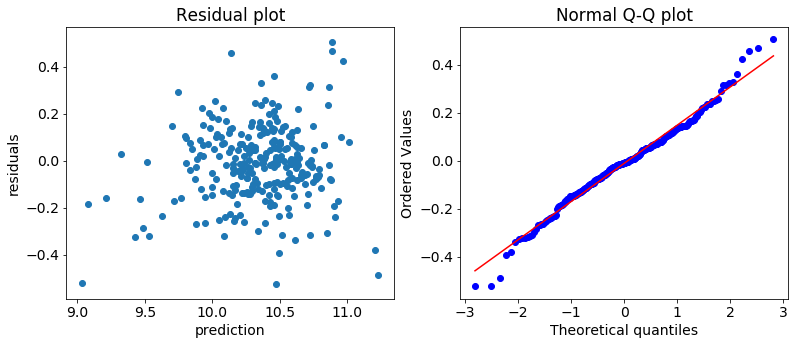

In [22]:
lasso_model, sorted_coefs, _ = lasso_pipeline(X_train, y_train, X_val, y_val)

# columns that were retained in the model
print('Num features: ', len(sorted_coefs))

Text(0.5, 0, 'coefficients')

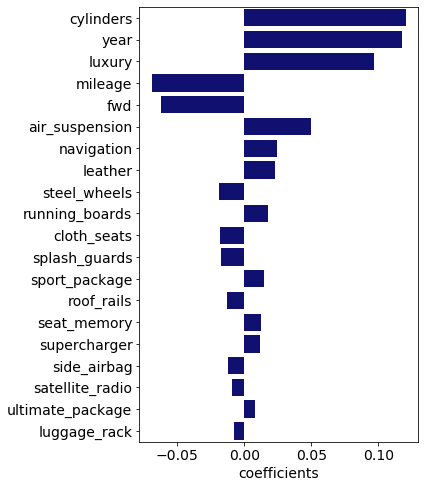

In [23]:
# Visual guide to feature influence in the model

plt.figure(figsize=(5,8))
sc = sorted_coefs[:20]
sns.barplot(data=sc, y=sc.index, x=sc['coef'], color='navy')
plt.ylabel('')
plt.xlabel('coefficients')

In [24]:
sorted_coefs.index.names = ['']
sorted_coefs = sorted_coefs.drop('abs_val', axis=1)
sorted_coefs['gain/loss per $1'] = np.round(sorted_coefs['price_ratio']-1,2)
np.round(sorted_coefs[:20], 3)


,coef,price_ratio,gain/loss per $1
,,,
cylinders,0.120,1.128,0.13
year,0.118,1.125,0.12
luxury,0.097,1.102,0.10
mileage,-0.069,0.934,-0.07
fwd,-0.062,0.940,-0.06
air_suspension,0.050,1.051,0.05
navigation,0.024,1.025,0.02
leather,0.023,1.023,0.02
steel_wheels,-0.019,0.982,-0.02


In [25]:
# There are still many uninformative features, so I will try increasing lasso regularization

lasso_model_higher_reg = Lasso(alpha=0.02, fit_intercept=True)

print('R^2: ' + str(cross_val_score(lasso_model_higher_reg, X_train, y_train, 
                                    cv=5, scoring='r2').mean()))

R^2: 0.8051249491011638


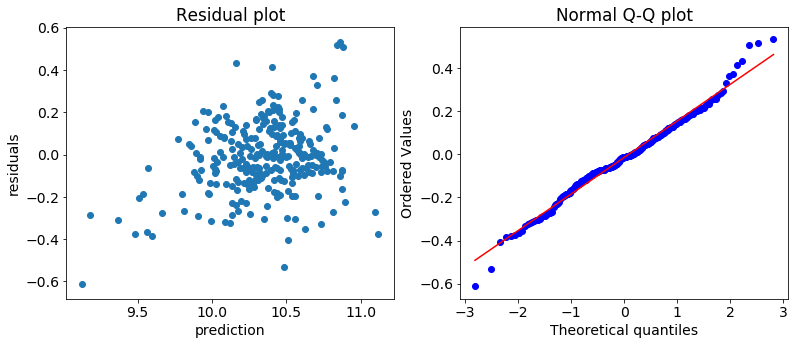

In [26]:
lasso_model_higher_reg.fit(X_train, y_train)

predictions = lasso_model_higher_reg.predict(X_val)

check_assumptions(y_val, predictions)

In [27]:
sorted_coefs = feature_coefs(X, lasso_model_higher_reg)
sorted_coefs.index

Index(['cylinders', 'year', 'luxury', 'fwd', 'mileage', 'air_suspension',
       'navigation', 'leather', 'cloth_seats', 'running_boards',
       'steel_wheels', 'sport_package', 'splash_guards', 'side_airbag',
       'supercharger', 'trailer_hitch', 'ultimate_package', 'driver_support',
       'fog_lights'],
      dtype='object', name=0)

Text(0.5, 0, 'coefficients')

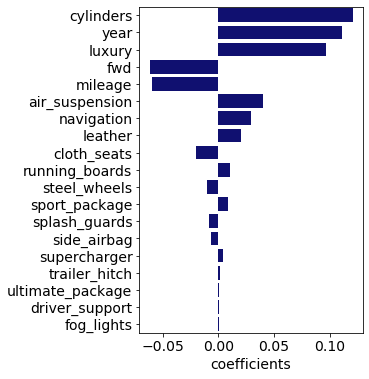

In [28]:
plt.figure(figsize=(4,6))
sns.barplot(data=sorted_coefs, y=sorted_coefs.index, x=sorted_coefs['coef'], color='navy')
plt.ylabel('')
plt.xlabel('coefficients')

## 3. Comparing with ElasticNet regularization

alpha: 0.0070671812739274914
l1_ratio: 0.8868421052631579
R^2: 0.8345119027670507


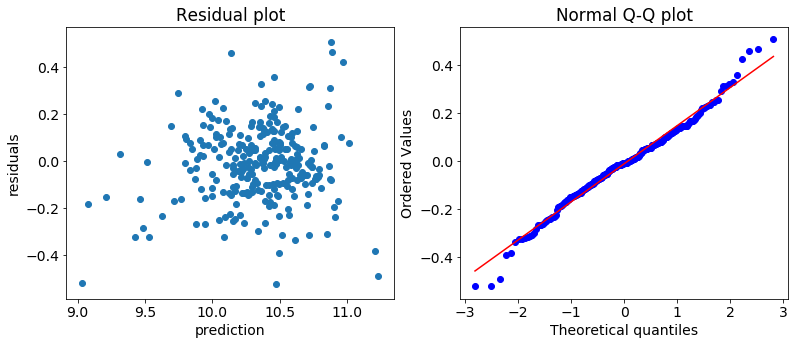

In [29]:
# ElasticNetCV search for optimal lambda and l1_ratio

en_model = optimize_ElasticNet(X_train, y_train, X_val, y_val)
sorted_coefs = feature_coefs(X, en_model) # sort coefficients by magnitude

en_model.fit(X_train, y_train)
predictions = en_model.predict(X_val)
check_assumptions(y_val, predictions) # plot residuals and Q-Q plot

# CV finds the maximum L1 ratio

Text(0.5, 0, 'coefficients')

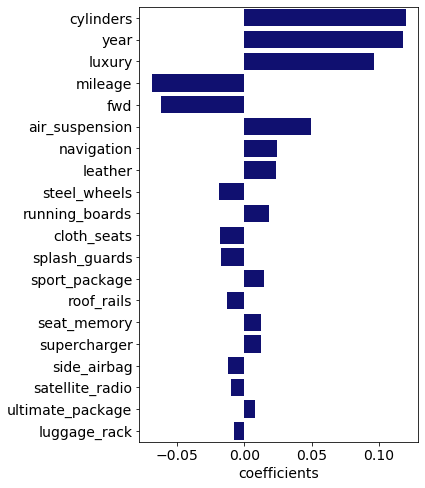

In [30]:
plt.figure(figsize=(5,8))
sc = sorted_coefs[:20]
sns.barplot(data=sc, y=sc.index, x=sc['coef'], color='navy')
plt.ylabel('')
plt.xlabel('coefficients')


## 5. Final model validation and results

In [31]:
# The lasso regularized model with increased alpha seems to be the most realistic so far, based on the residuals, 
# scoring, and simplicity of interpretation.

lasso_model_higher_reg = Lasso(alpha=0.01, fit_intercept=True)
lasso_model_higher_reg.fit(X_train, y_train)

print('R^2: ' + str(cross_val_score(lasso_model_higher_reg, X_train, y_train, 
                                    cv=5, scoring='r2').mean()))

print('R^2 test: ' + str(lasso_model_higher_reg.score(X_test, y_test)))


R^2: 0.8247782556736002
R^2 test: 0.7899128968878091


In [33]:
sorted_coefs = feature_coefs(X, lasso_model_higher_reg)
sorted_coefs.index.names = ['']
sorted_coefs = sorted_coefs.drop('abs_val', axis=1)
sorted_coefs['gain/loss per $1'] = np.round(sorted_coefs['price_ratio']-1,2)
np.round(sorted_coefs[:20], 3)


,coef,price_ratio,gain/loss per $1
,,,
cylinders,0.121,1.129,0.13
year,0.116,1.123,0.12
luxury,0.095,1.100,0.10
mileage,-0.067,0.936,-0.06
fwd,-0.064,0.938,-0.06
air_suspension,0.047,1.048,0.05
navigation,0.025,1.025,0.02
leather,0.021,1.022,0.02
cloth_seats,-0.020,0.981,-0.02
